In [1]:
#import importlib_resources
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.linalg import svd

from sklearn.preprocessing import StandardScaler

import seaborn as sns

from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

## Data loading

In [2]:
filename = 'data/abalone.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(filename)


#clean the column names
df.columns = df.columns.str.replace('"', '')
df.columns = df.columns.str.strip()

In [3]:
df.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

In [4]:
raw_data = df.values

y = raw_data[:, 8].astype(float) + 1.5  # Rings + 1.5 for age
print(y)

[16.5  8.5 10.5 ... 10.5 11.5 13.5]


### X without including Sex

In [5]:
cols = range(1, 8) 

X = raw_data[:, cols]

#print(X)

attributeNames = np.asarray(df.columns[cols])

print(attributeNames)

['Length' 'Diameter' 'Height' 'Whole weight' 'Shucked weight'
 'Viscera weight' 'Shell weight']


In [6]:
N, M = X.shape # number of rows (samples) and columns (attributes)

N, M

(4177, 7)

### X including Sex as 3 different variables

In [7]:
#One-Hot Encoding of the Sex column
df_dummies = df.copy()
df_dummies = pd.get_dummies(df_dummies, columns=['Sex'], drop_first=False)

df_dummies['Sex_F'] = df_dummies['Sex_F'].astype(int)
df_dummies['Sex_M'] = df_dummies['Sex_M'].astype(int)
df_dummies['Sex_I'] = df_dummies['Sex_I'].astype(int)

df_dummies.head()

Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  Sex_F  Sex_I  Sex_M  
0         0.150     15      0      0      1  
1         0.070      7      0      0      1  
2         0.210      9      1      0      0  
3         0.155     10      0      0      1  
4         0.055      7      0      1      0

In [8]:
raw_data = df_dummies.values


cols = [0,1,2,3,4,5,6,8,9,10]

X_OH = raw_data[:, cols]

#print(X)

attributeNames_OH = np.asarray(df_dummies.columns[cols])

print(attributeNames_OH)

['Length' 'Diameter' 'Height' 'Whole weight' 'Shucked weight'
 'Viscera weight' 'Shell weight' 'Sex_F' 'Sex_I' 'Sex_M']


## Attribute analysis

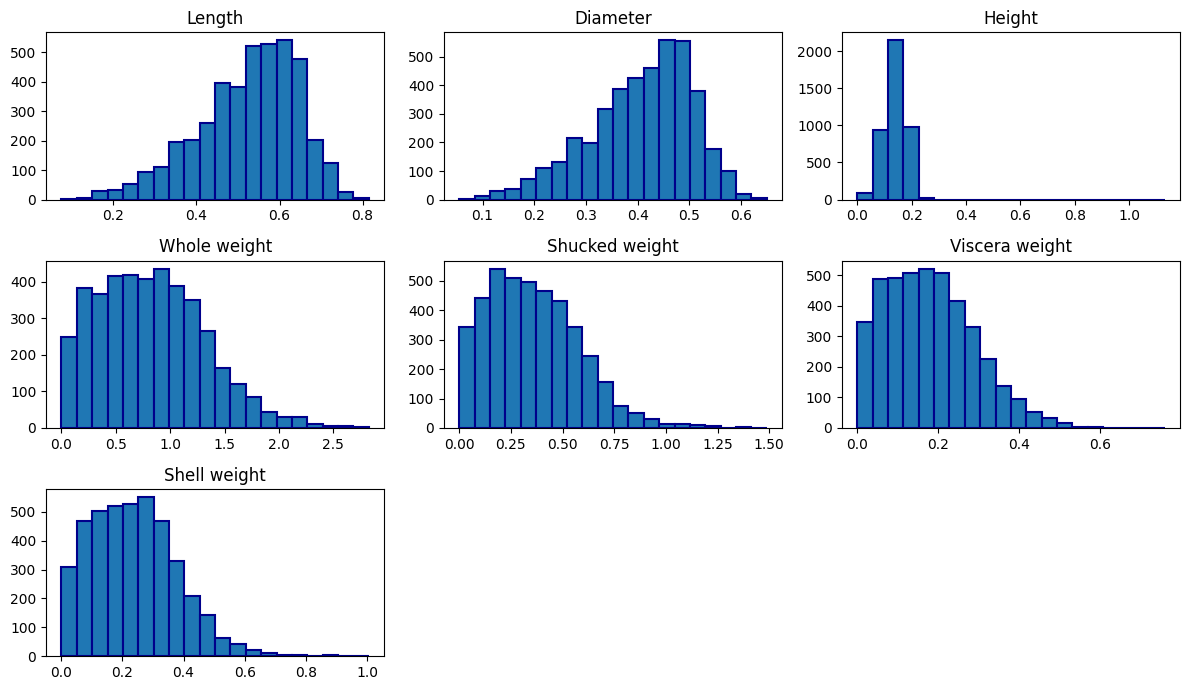

In [9]:
#Histogram plot
plt.figure(figsize = (12,7))
for i, (attr, attrname) in enumerate(zip(X.T,attributeNames)):
    plt.subplot(3,3,i+1)
    plt.hist(attr, bins = 20, edgecolor='darkblue', linewidth=1.5)
    plt.title(attrname)
plt.tight_layout()
plt.show()

According to the data description provided with the dataset, the attributes are measured in different units (mm and g). To address this, we will standardize the data.

In [10]:
scaler = StandardScaler() #this scaler object will scale data column by column
stand_X = scaler.fit_transform(X)  
stand_X_OH = scaler.fit_transform(X_OH)  

In [11]:
X_remove = stand_X.copy()

for i in range(2):
    outlier_max = np.argmax(X_remove[:, 2])
    X_remove = np.delete(X_remove, (outlier_max), axis=0)
    y = np.delete(y, (outlier_max), axis=0)
    outlier_min = np.argmin(X_remove[:, 2])
    X_remove = np.delete(X_remove, (outlier_min), axis=0)
    y = np.delete(y, (outlier_min), axis=0)

In [12]:
X_remove_OH = stand_X_OH.copy()
for i in range(2):
    outlier_max = np.argmax(X_remove_OH[:,2])
    X_remove_OH = np.delete(X_remove_OH, (outlier_max), axis=0)
    outlier_min = np.argmin(X_remove_OH[:,2])
    X_remove_OH = np.delete(X_remove_OH, (outlier_min), axis=0)

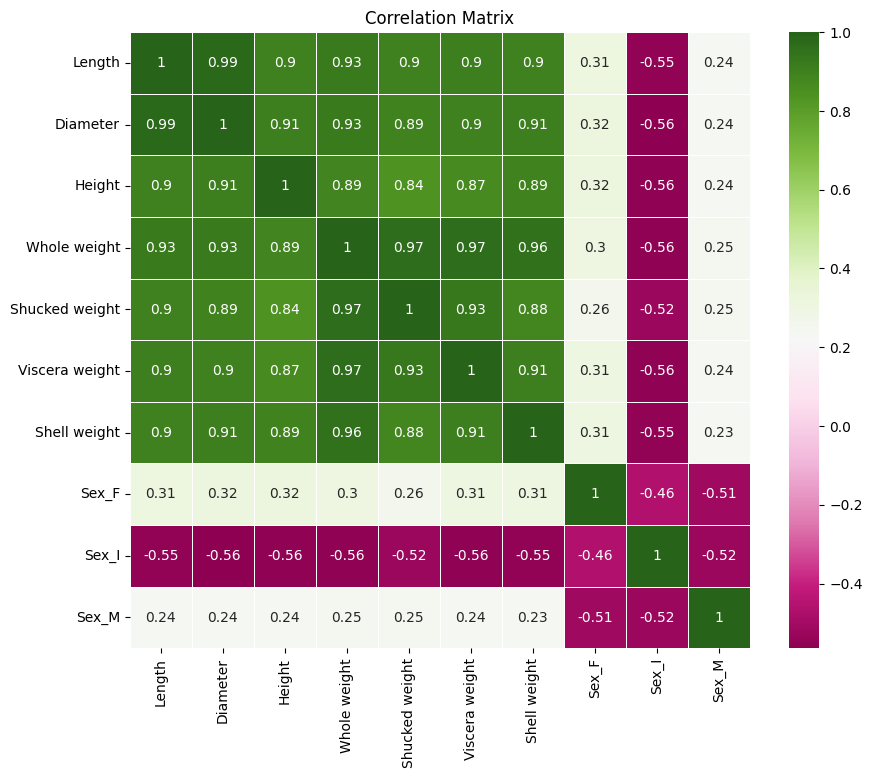

In [13]:
# Correlation plot
correlation_matrix = np.corrcoef(X_remove_OH, rowvar=False)

# Create the correlation plot
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='PiYG', xticklabels=attributeNames_OH, yticklabels=attributeNames_OH, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

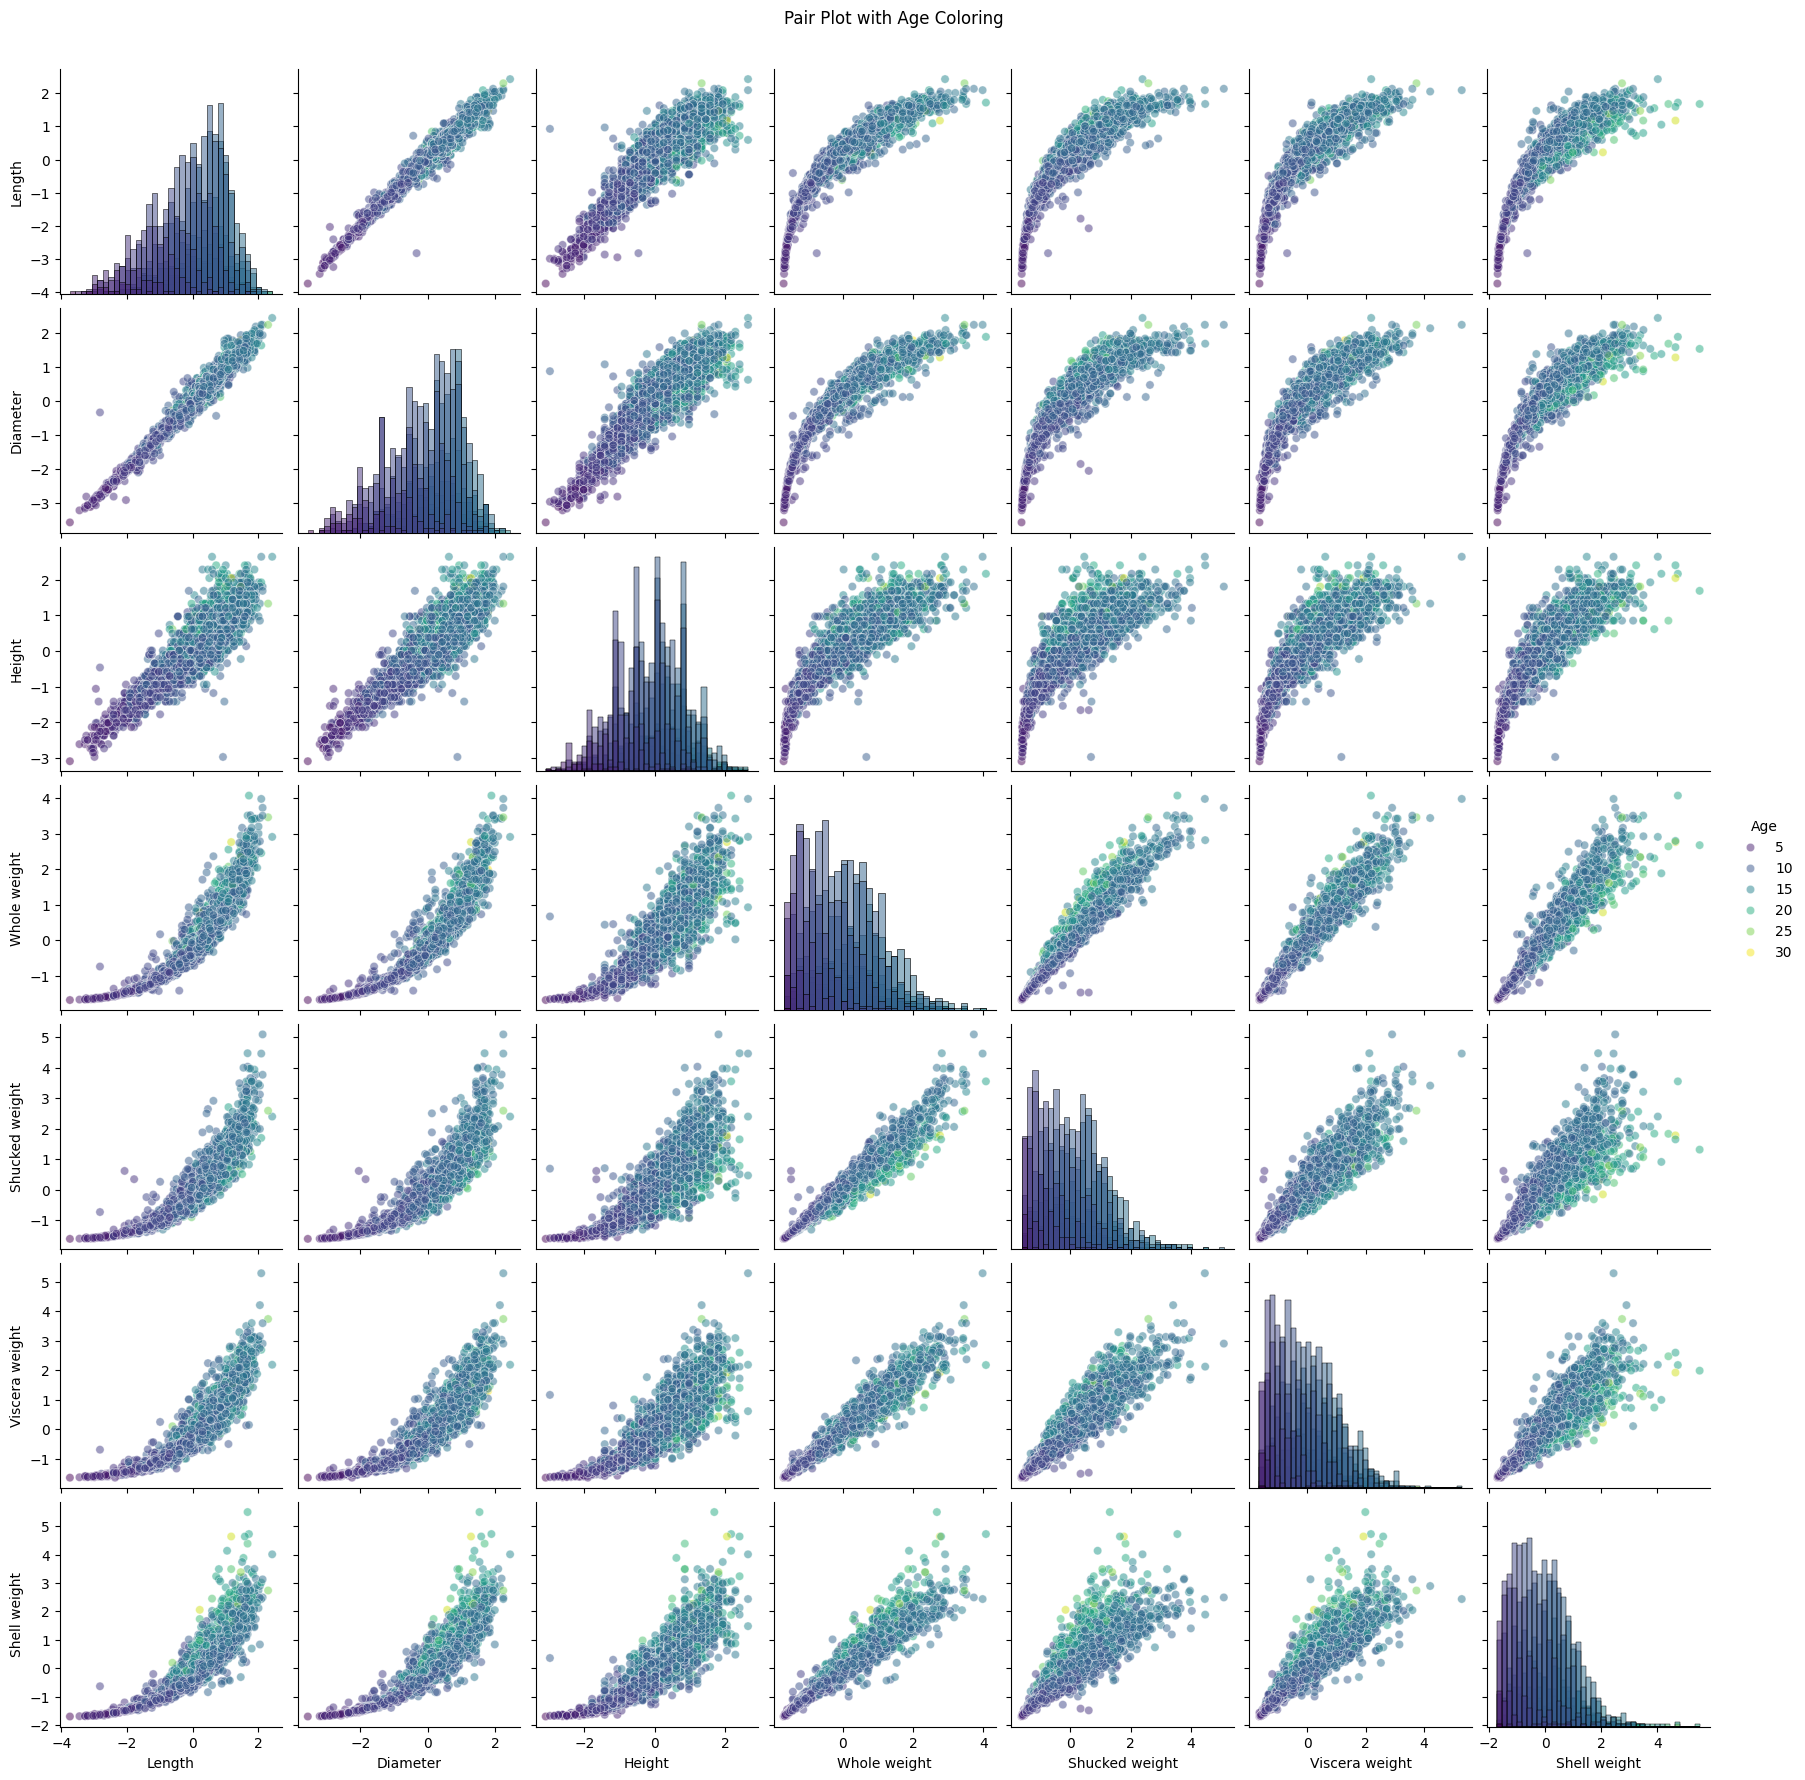

In [14]:
# Create a DataFrame
df = pd.DataFrame(X_remove, columns=attributeNames)
df['Age'] = y

# Create the pair plot with color coding
sns.pairplot(df, hue='Age', palette='viridis', diag_kind='hist', markers='o', plot_kws={'alpha': 0.5})
plt.suptitle('Pair Plot with Age Coloring', y=1.02)
plt.show()

After doing a first draft of a box-plot, we saw that there were some outliers in the height attribute. After inspecting the documentation, we decided to remove them. We do that in both the X without the Sex and with the variables for Sex.

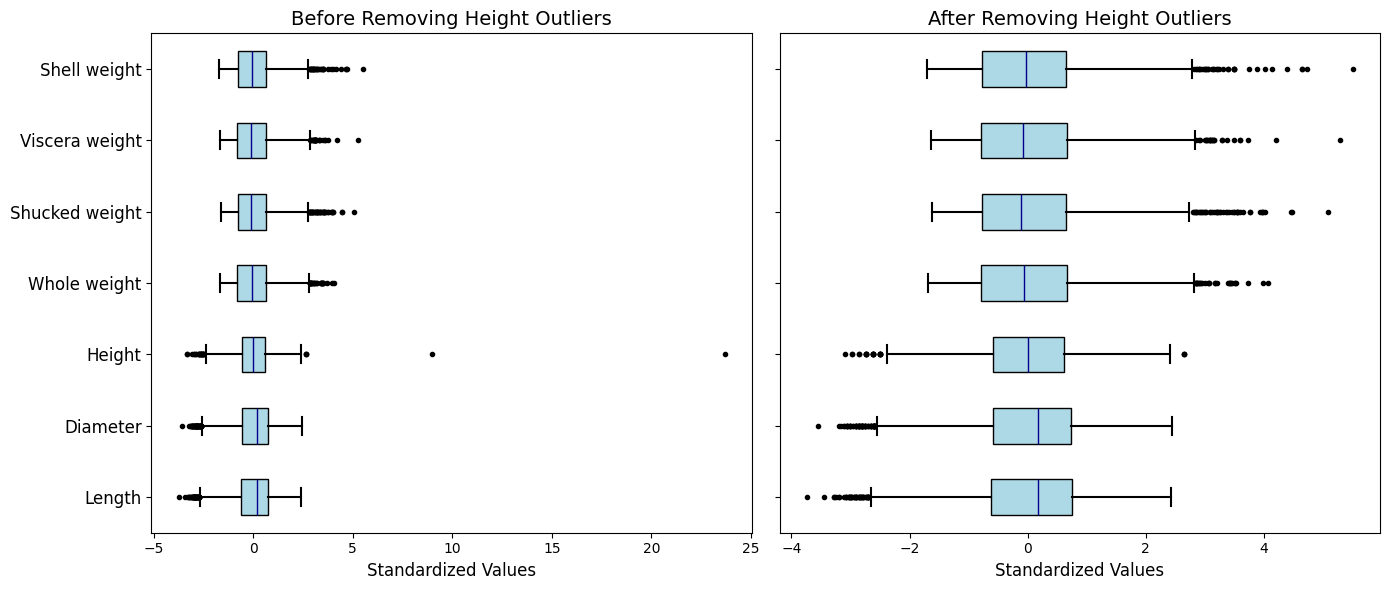

In [15]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Boxplot before removing outliers
axes[0].boxplot(stand_X, patch_artist=True, vert=False,
                boxprops=dict(facecolor="lightblue", color="black"),
                medianprops=dict(color="darkblue", linewidth=1),
                whiskerprops=dict(color="black", linewidth=1.5),
                capprops=dict(color="black", linewidth=1.5),
                flierprops=dict(marker='o', markersize=3, markerfacecolor="black", alpha=1))
axes[0].set_yticks(range(1, 8))
axes[0].set_yticklabels(attributeNames[:7], fontsize=12)
axes[0].set_xlabel("Standardized Values", fontsize=12)
axes[0].set_title("Before Removing Height Outliers", fontsize=14)


# Boxplot after removing outliers
axes[1].boxplot(X_remove, patch_artist=True, vert=False,
                boxprops=dict(facecolor="lightblue", color="black"),
                medianprops=dict(color="darkblue", linewidth=1),
                whiskerprops=dict(color="black", linewidth=1.5),
                capprops=dict(color="black", linewidth=1.5),
                flierprops=dict(marker='o', markersize=3, markerfacecolor="black", alpha=1))
axes[1].set_yticks(range(1, 8))
axes[1].set_yticklabels(attributeNames[:7], fontsize=12)
axes[1].set_xlabel("Standardized Values", fontsize=12)
axes[1].set_title("After Removing Height Outliers", fontsize=14)

plt.tight_layout()
plt.show()

## PCA - including Sex

In [16]:
X_remove_OH = np.array(X_remove_OH, dtype=np.float64) # standarized data with outliers removed

In [17]:
N, M = X_remove_OH.shape # number of rows (samples) and columns (attributes)

N, M

(4173, 10)

### Variance explained by the components

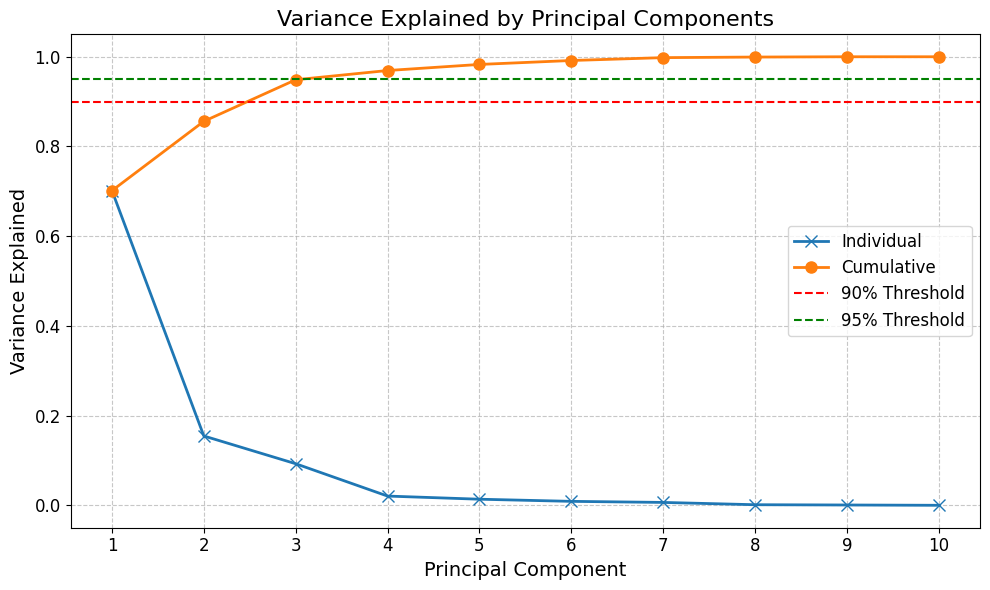

In [18]:
# Subtract mean value from data
# Note: Here we use Y to in teh book we often use X with a hat-symbol on top.
Y = X_remove_OH - np.ones((N, 1)) * X_remove_OH.mean(axis=0)

# Note: Here we call the Sigma matrix in the SVD S for notational convinience
U, S, Vh = svd(Y, full_matrices=False)

# scipy.linalg.svd returns "Vh", which is the Hermitian (transpose)
# of the vector V. So, for us to obtain the correct V, we transpose:
V = Vh.T

# Compute variance explained by principal components 
# Note: This is an important equation, see Eq. 3.18 on page 40 in the book.
rho = (S * S) / (S * S).sum()

#threshold = 0.9

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(rho) + 1), rho, "x-", label="Individual", markersize=8, linewidth=2)
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-", label="Cumulative", markersize=8, linewidth=2)

# Plot the threshold lines
plt.axhline(y=0.9, color="red", linestyle="--", label="90% Threshold")
plt.axhline(y=0.95, color="green", linestyle="--", label="95% Threshold")

# Add titles and labels
plt.title("Variance Explained by Principal Components", fontsize=16)
plt.xlabel("Principal Component", fontsize=14)
plt.ylabel("Variance Explained", fontsize=14)
plt.xticks(range(1, len(rho) + 1), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

### Data projection into the components

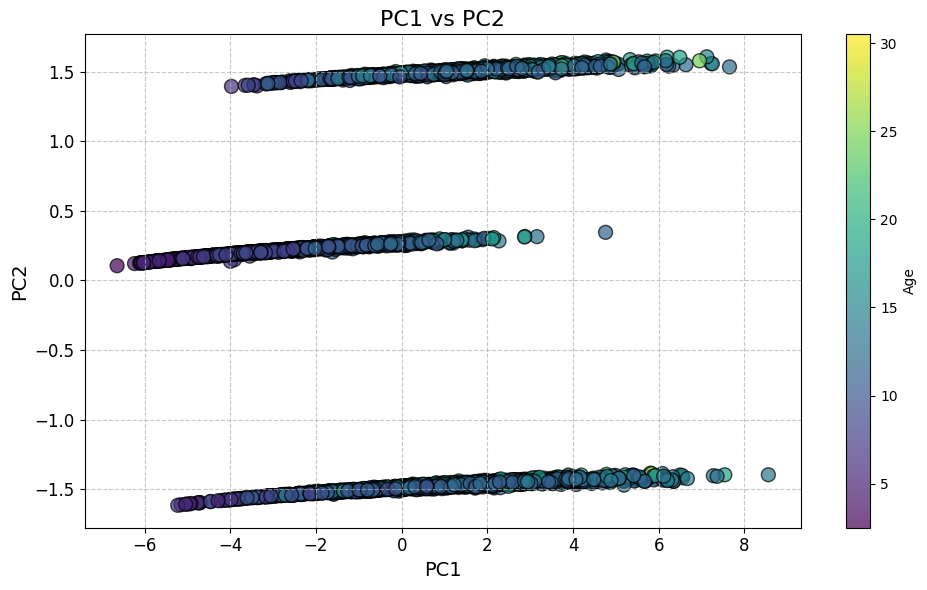

In [19]:
# Project the centered data onto principal component space
Z = Y @ V

# Indices of the principal components to be plotted (PC1 and PC2)
i = 0
j = 1

# Plot PCA of the data
plt.figure(figsize=(10, 6))
plt.scatter(Z[:, i], Z[:, j], c=y, cmap="viridis", alpha=0.7, edgecolor='k', s=100)
plt.colorbar(label="Age")
plt.title("PC1 vs PC2", fontsize=16)
plt.xlabel(f"PC{i+1}", fontsize=14)
plt.ylabel(f"PC{j+1}", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

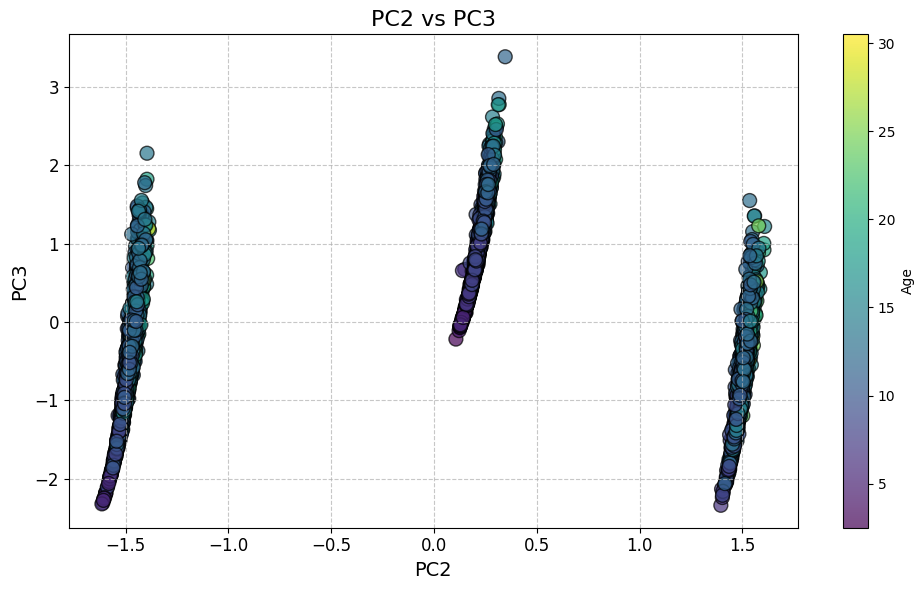

In [20]:
i = 1
j = 2

# Plot PCA of the data
plt.figure(figsize=(10, 6))
plt.scatter(Z[:, i], Z[:, j], c=y, cmap="viridis", alpha=0.7, edgecolor='k', s=100)
plt.colorbar(label="Age")
plt.title("PC2 vs PC3", fontsize=16)
plt.xlabel(f"PC{i+1}", fontsize=14)
plt.ylabel(f"PC{j+1}", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

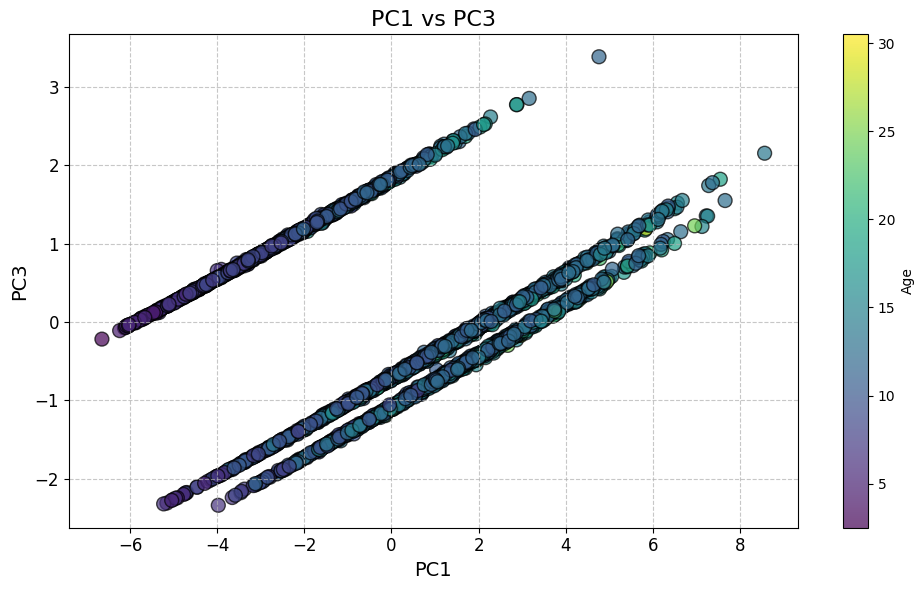

In [21]:
i = 0
j = 2

# Plot PCA of the data
plt.figure(figsize=(10, 6))
plt.scatter(Z[:, i], Z[:, j], c=y, cmap="viridis", alpha=0.7, edgecolor='k', s=100)
plt.colorbar(label="Age")
plt.title("PC1 vs PC3", fontsize=16)
plt.xlabel(f"PC{i+1}", fontsize=14)
plt.ylabel(f"PC{j+1}", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

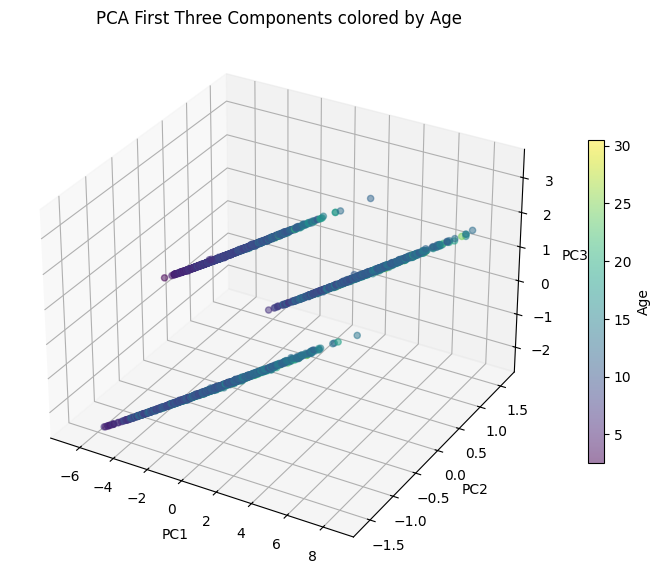

In [22]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=y, cmap="viridis", alpha=0.5)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA First Three Components colored by Age")

# Add color bar for Age
cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Age")

plt.show()

### Contribution of the attributes to each component

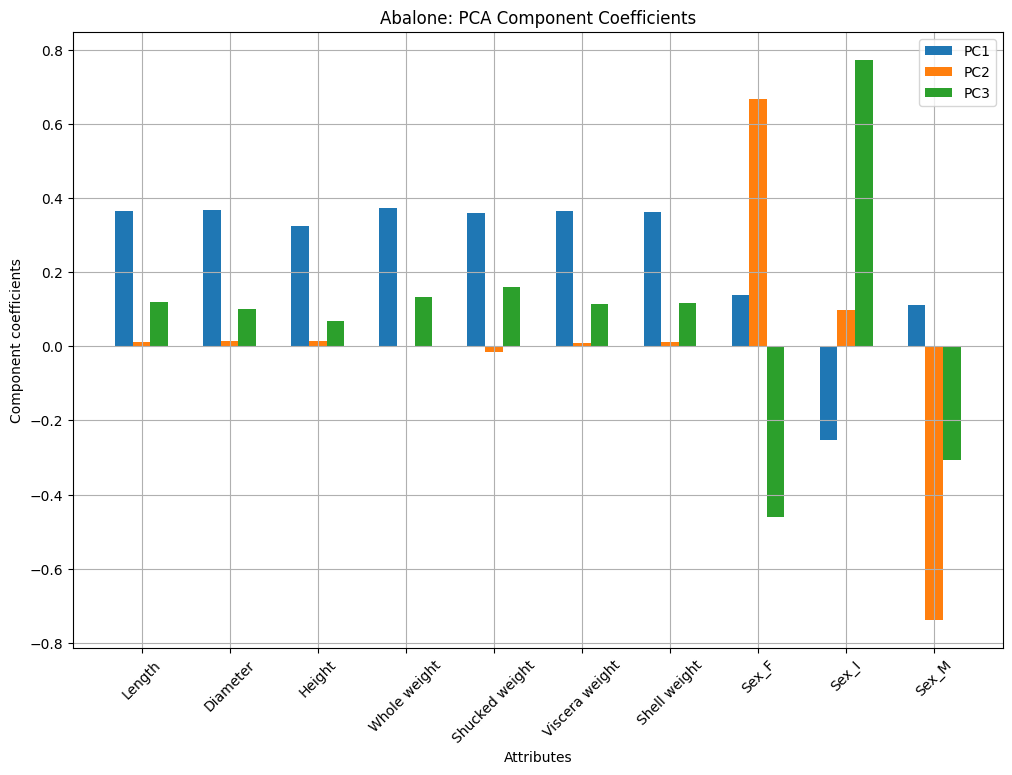

In [23]:
pcs = [0, 1, 2]
legendStrs = ["PC" + str(e + 1) for e in pcs]
bw = 0.2
r = np.arange(1, M + 1)

plt.figure(figsize=(12, 8))

for i in pcs:
    plt.bar(r + i * bw, V[:, i], width=bw)

plt.xticks(r + bw,attributeNames_OH, rotation = 45)
plt.xlabel("Attributes")
plt.ylabel("Component coefficients")
plt.legend(legendStrs)
plt.grid()
plt.title("Abalone: PCA Component Coefficients")
plt.show()

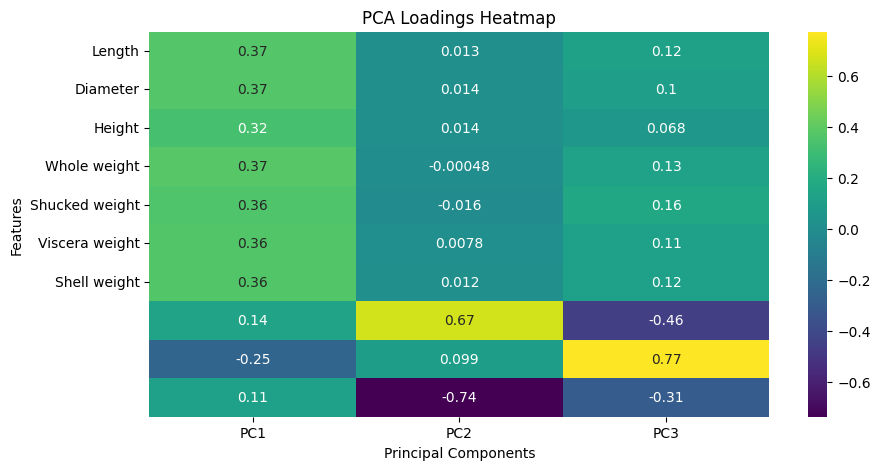

In [24]:
plt.figure(figsize=(10, 5))
sns.heatmap(V[:, :3], annot=True, cmap="viridis", xticklabels=["PC1", "PC2", "PC3"], yticklabels=attributeNames)
plt.title("PCA Loadings Heatmap")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.show()

## PCA - without Sex

In [25]:
X_remove = np.array(X_remove, dtype=np.float64) # standarized data with outliers removed

In [26]:
N, M = X_remove.shape # number of rows (samples) and columns (attributes)

N, M

(4173, 7)

### Variance explained by the components

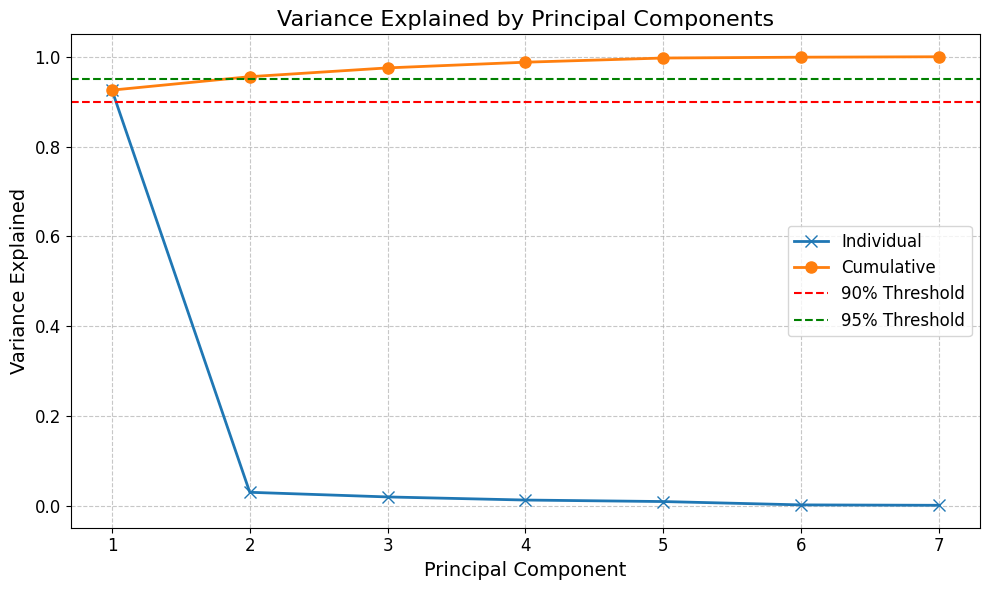

In [27]:
# Subtract mean value from data
# Note: Here we use Y to in teh book we often use X with a hat-symbol on top.
Y = X_remove - np.ones((N, 1)) * X_remove.mean(axis=0)

# Note: Here we call the Sigma matrix in the SVD S for notational convinience
U, S, Vh = svd(Y, full_matrices=False)

# scipy.linalg.svd returns "Vh", which is the Hermitian (transpose)
# of the vector V. So, for us to obtain the correct V, we transpose:
V = Vh.T

# Compute variance explained by principal components 
# Note: This is an important equation, see Eq. 3.18 on page 40 in the book.
rho = (S * S) / (S * S).sum()

#threshold = 0.9

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(rho) + 1), rho, "x-", label="Individual", markersize=8, linewidth=2)
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-", label="Cumulative", markersize=8, linewidth=2)

# Plot the threshold lines
plt.axhline(y=0.9, color="red", linestyle="--", label="90% Threshold")
plt.axhline(y=0.95, color="green", linestyle="--", label="95% Threshold")

# Add titles and labels
plt.title("Variance Explained by Principal Components", fontsize=16)
plt.xlabel("Principal Component", fontsize=14)
plt.ylabel("Variance Explained", fontsize=14)
plt.xticks(range(1, len(rho) + 1), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


More than the 95% of the variabily is explained with the first two component, which leads us to think that we don't need more components.

### Data projection into the components

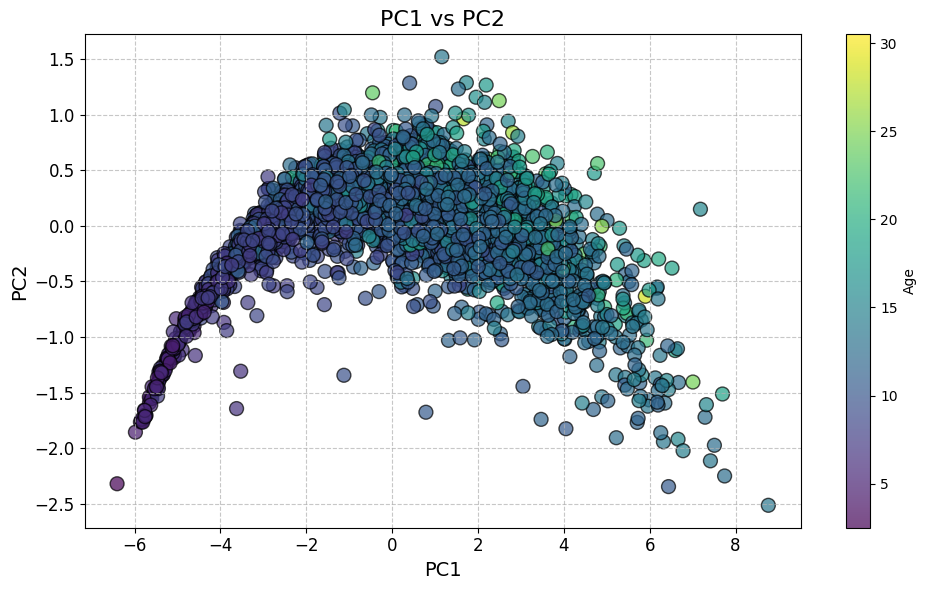

In [28]:
# Project the centered data onto principal component space
Z = Y @ V

# Indices of the principal components to be plotted (PC1 and PC2)
i = 0
j = 1

# Plot PCA of the data
plt.figure(figsize=(10, 6))
plt.scatter(Z[:, i], Z[:, j], c=y, cmap="viridis", alpha=0.7, edgecolor='k', s=100)
plt.colorbar(label="Age")
plt.title("PC1 vs PC2", fontsize=16)
plt.xlabel(f"PC{i+1}", fontsize=14)
plt.ylabel(f"PC{j+1}", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

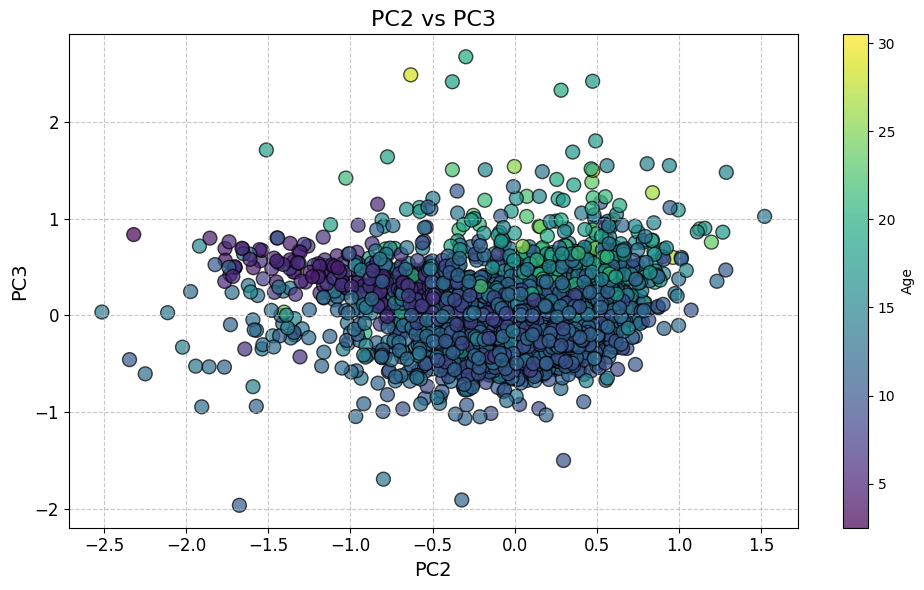

In [29]:
i = 1
j = 2

# Plot PCA of the data
plt.figure(figsize=(10, 6))
plt.scatter(Z[:, i], Z[:, j], c=y, cmap="viridis", alpha=0.7, edgecolor='k', s=100)
plt.colorbar(label="Age")
plt.title("PC2 vs PC3", fontsize=16)
plt.xlabel(f"PC{i+1}", fontsize=14)
plt.ylabel(f"PC{j+1}", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

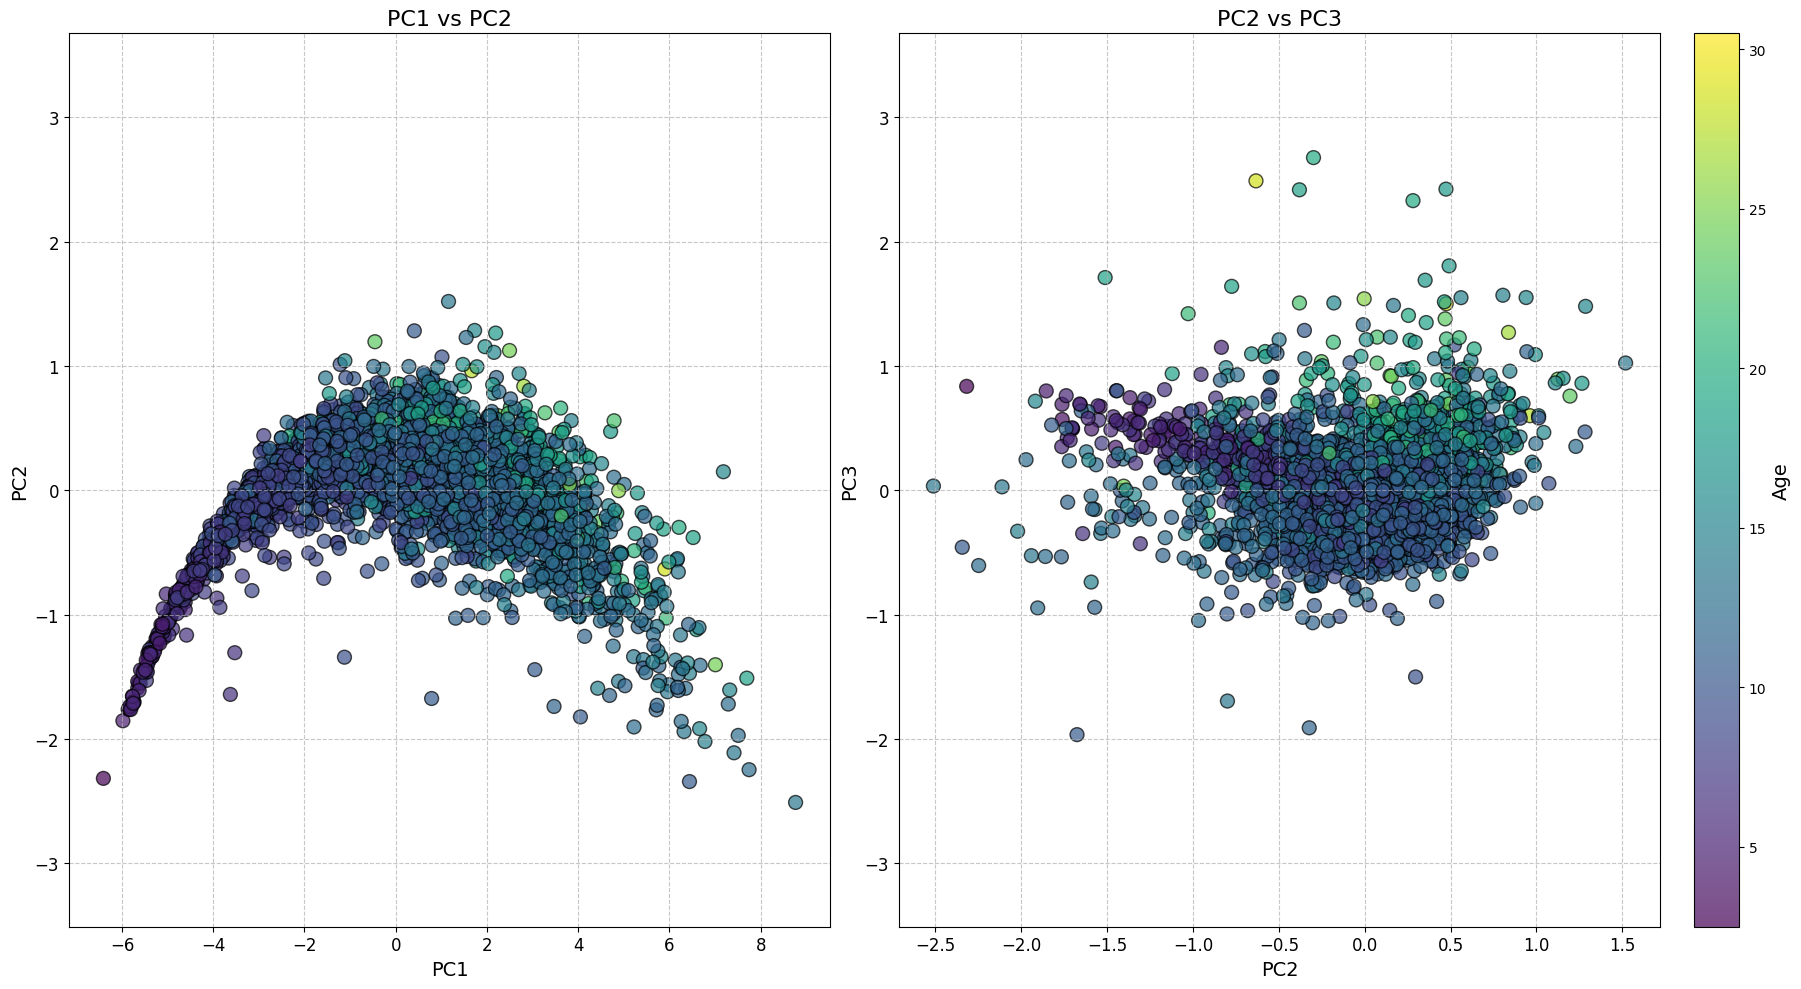

In [30]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Determine the limits for the Y-axis to ensure the same scale
y_limits = [min(Z[:, 1].min(), Z[:, 2].min()) - 1, max(Z[:, 1].max(), Z[:, 2].max()) + 1]

# Plot PC1 vs PC2
i, j = 0, 1
scatter1 = axes[0].scatter(Z[:, i], Z[:, j], c=y, cmap="viridis", alpha=0.7, edgecolor='k', s=100)
axes[0].set_title("PC1 vs PC2", fontsize=16)
axes[0].set_xlabel(f"PC{i+1}", fontsize=14)
axes[0].set_ylabel(f"PC{j+1}", fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_ylim(y_limits)

# Plot PC2 vs PC3
i, j = 1, 2
scatter2 = axes[1].scatter(Z[:, i], Z[:, j], c=y, cmap="viridis", alpha=0.7, edgecolor='k', s=100)
axes[1].set_title("PC2 vs PC3", fontsize=16)
axes[1].set_xlabel(f"PC{i+1}", fontsize=14)
axes[1].set_ylabel(f"PC{j+1}", fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_ylim(y_limits)

# Adjust the layout to make space for the colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add a colorbar at the right
cbar = fig.colorbar(scatter2, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label("Age", fontsize=14)

plt.show()

### Contribution of the attributes to each component

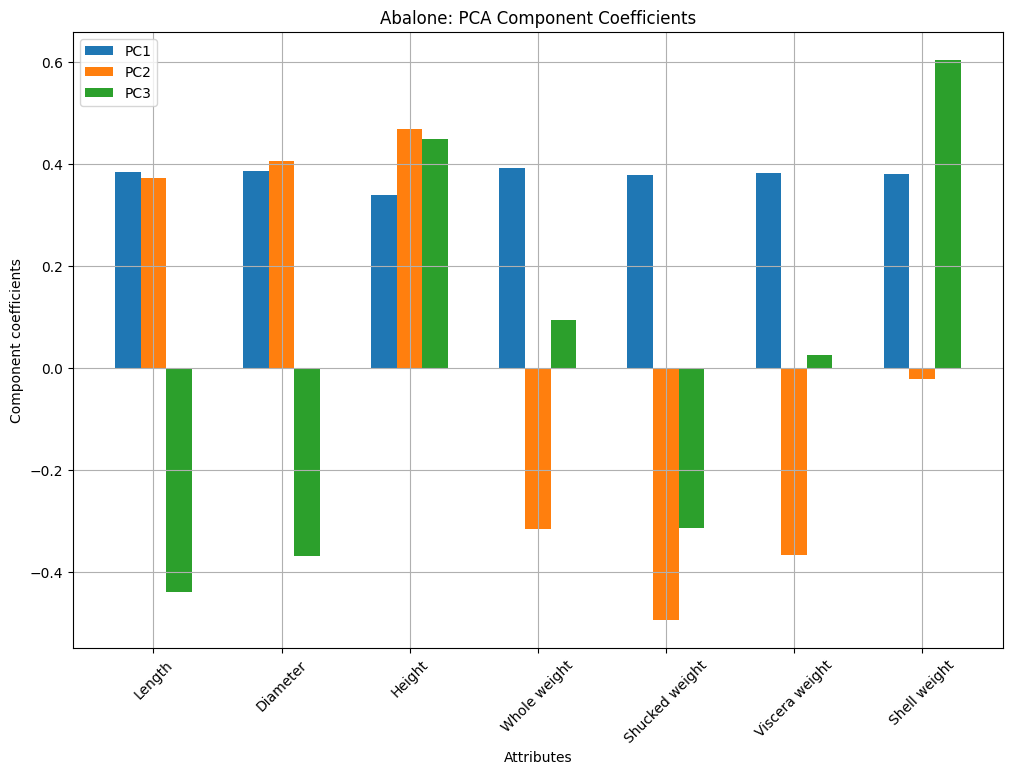

In [31]:
pcs = [0, 1, 2]
legendStrs = ["PC" + str(e + 1) for e in pcs]
bw = 0.2
r = np.arange(1, M + 1)

plt.figure(figsize=(12, 8))

for i in pcs:
    plt.bar(r + i * bw, V[:, i], width=bw)

plt.xticks(r + bw,attributeNames, rotation = 45)
plt.xlabel("Attributes")
plt.ylabel("Component coefficients")
plt.legend(legendStrs)
plt.grid()
plt.title("Abalone: PCA Component Coefficients")
plt.show()

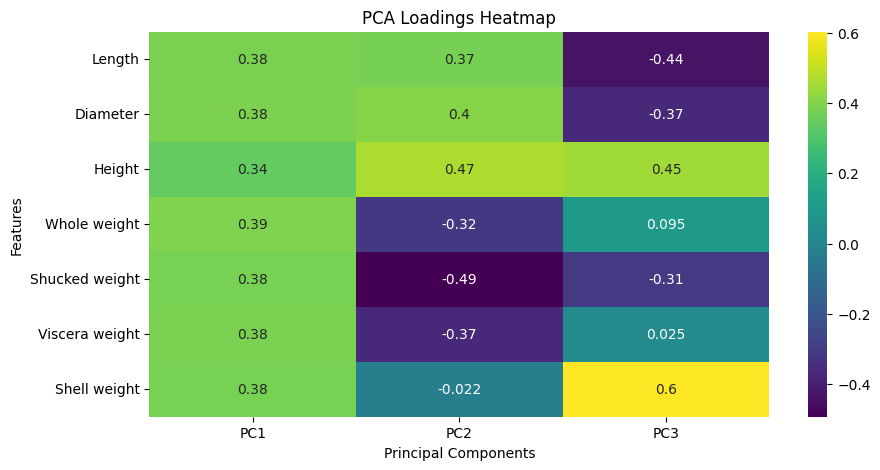

In [32]:
plt.figure(figsize=(10, 5))
sns.heatmap(V[:, :3], annot=True, cmap="viridis", xticklabels=["PC1", "PC2", "PC3"], yticklabels=attributeNames)
plt.title("PCA Loadings Heatmap")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.show()


All the variables contribute more or less the same to the first component.

### Relation between age and PC1

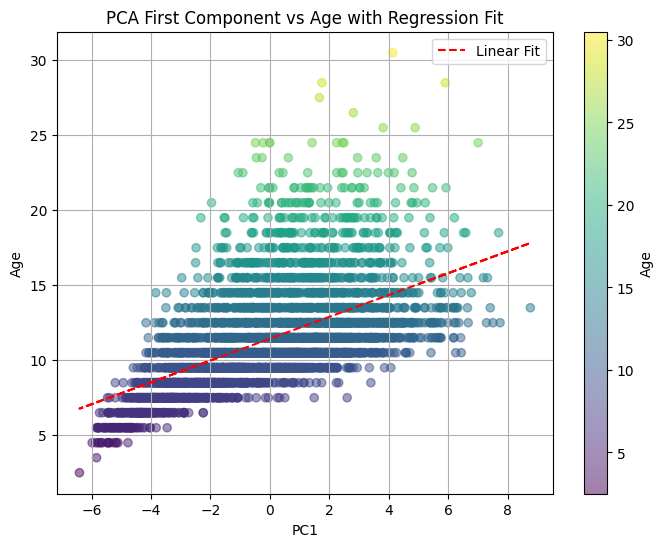

In [33]:
# Fit a simple regression model to PC1 vs Age
reg = LinearRegression()
reg.fit(Z[:, [0]], y)
y_pred = reg.predict(Z[:, [0]])

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
plt.scatter(Z[:, 0], y, c=y, cmap="viridis", alpha=0.5)
plt.plot(Z[:, 0], y_pred, "r--", label="Linear Fit")
plt.colorbar(label="Age")
plt.xlabel("PC1")
plt.ylabel("Age")
plt.title("PCA First Component vs Age with Regression Fit")
plt.legend()
plt.grid()
plt.show()